In [5]:
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
from numpy import interp
from math import tau
from scipy.integrate import quad
import requests
from io import BytesIO

class ImageReader:
    """ Read the url that contains an image in JPG, JPEG or PNG format then converting into coordinates.
    """
    def __init__(self, url):
        """Constructor
        Read the image and convert to gray scale
        Threshold the gray image to get pure black and white image
        :param url: link that points to the image
        :type x_table: url
        """
        self.url = url
        response = requests.get(url)
        self.img = Image.open(BytesIO(response.content))
        self.im = self.img.convert("L")
        
    
    def get_tour(self, level= [200]):
        """
        Find the contour of image
        Split the points and store in x_table and y_table
        Centering the points to origin: (0,0)
        Make a time table from 0 to 2PI
        :param x_table: coordinate of the X axis
        :type x_table: float
        :param y_table: coordinate on the Y axis
        :type y_table: float
        :param time_table: time list from 0 to 2PI
        :type time_table: float
        """

        contour_plot = plt.contour(self.im,levels = level,origin='image')
        contour_path = contour_plot.collections[0].get_paths()[0]
        x_table, y_table = contour_path.vertices[:,0], contour_path.vertices[:,1]

        #Center X and Y
        x_table = x_table - min(x_table)
        y_table = y_table - min(y_table)
        x_table = x_table - max(x_table)/2
        y_table = y_table - max(y_table)/2

        #Visualize
        plt.plot(x_table, y_table)
        #For the period of time 0-2*pi
        time_table = np.linspace(0,tau,len(x_table))

        self.x_table = x_table
        self.y_table = y_table
        self.time_table = time_table
        
        return self.time_table, self.x_table, self.y_table

import matplotlib.pyplot as plt
import numpy as np
from math import tau
from scipy.integrate import quad
from numpy import interp

def f(t, time_table, x_table, y_table):
            #Convert the X and Y coords to complex number over time
            X = np.interp(t, time_table, x_table) 
            Y = 1j*np.interp(t, time_table, y_table)
            return X + Y

class Fourier : 

    def __init__(self, time_table, x_table, y_table, order) :
        self.order = order
        self.time_table = time_table
        self.x_table = x_table
        self.y_table = y_table

    def coef_list(self,time_table, x_table, y_table, order) :
        coef_list = []
            
        for n in range(-order, order+1):
        #integrate across f .
            real_coef = quad(lambda t: np.real(f(t, time_table, x_table, y_table) * np.exp(-n*1j*t)), 0, tau, limit=100, full_output=1)[0]/tau
            imag_coef = quad(lambda t: np.imag(f(t, time_table, x_table, y_table) * np.exp(-n*1j*t)), 0, tau, limit=100, full_output=1)[0]/tau
            coef_list.append([real_coef, imag_coef])

        return np.array(coef_list)


    def DFT(self, t, coef_list, order):
    #Compute the discrete fourier series with a given order
        kernel = np.array([np.exp(-n*1j*t) for n in range(-order, order+1)])
        series = np.sum( (coef_list[:,0]+1j*coef_list[:,1]) * kernel[:])

        return np.real(series), np.imag(series)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, animation
from matplotlib.patches import ConnectionPatch
from math import tau
import cmath

class DrawAnimation:
    """Creates an animation that draws a curve representing an image using Fourier coefficients.
    
    :param x_DFT: Real part of the Fourier transform.
    :type x_DFT: list.
    :param y_DFT: Imaginary part of the Fourier transform.
    :type y_DFT: list.
    :param coef: Fourier coefficients.
    :type coef: ndarray.
    :param order: Variable that we use to determine the number of Fourier coefficients that we will generate.
    :type order: int.
    :param space: Variable used to give the number of images for the animation
    :type space: tuple.
    :param fig_lim: Define the limit of the x and y axes of our plot.
    :type fig_lim: list.
    """
    def __init__(self, x_DFT, y_DFT, coef, order, space, fig_lim):
        """
            Construction method
        """
        self.x_DFT = x_DFT
        self.y_DFT = y_DFT
        self.coef = coef 
        self.order = order
        self.space = space
        self.fig_lim = fig_lim
        
    def visualize(self, x_DFT, y_DFT, coef, order, space, fig_lim):
        """
            Creates the drawing of the image and spinning circles animation.
        """
        fig, ax = plt.subplots()
        lim = max(fig_lim)
        ax.set_xlim([-lim, lim])
        ax.set_ylim([-lim, lim])
        ax.set_aspect('equal')

        # Initialize
        line = plt.plot([], [], 'k-', linewidth=2)[0]
        radius = [plt.plot([], [], 'r-', linewidth=0.5, marker='o', markersize=1)[0] for _ in range(2 * order + 1)]
        circles = [plt.plot([], [], 'r-', linewidth=0.5)[0] for _ in range(2 * order + 1)]

        def update_c(c, t):
            """
                Creates a new ndarray new_c for plot radius in each circle and plot each circle in the 
                function animate.
            """
            new_c = []
            for i, j in enumerate(range(-order, order + 1)):
                dtheta = -j * t
                ct, st = np.cos(dtheta), np.sin(dtheta)
                v = [ct * c[i][0] - st * c[i][1], st * c[i][0] + ct * c[i][1]]
                new_c.append(v)
            return np.array(new_c)

        def sort_velocity(order):
            """
                Creates a variable that iterates through the numbers between order+i and order-i.
            """
            idx = []
            for i in range(1,order+1):
                idx.extend([order+i, order-i]) 
            return idx    

        def animate(i):
            # animate lines
            """ 
                Displays the radius of each circle as well as the circle. This function also plots the approximation of the image.
            """
            line.set_data(x_DFT[:i], y_DFT[:i])
            # array of radius of each circles
            r = [np.linalg.norm(coef[j]) for j in range(len(coef))]
            # position is on the last circle
            pos = coef[order]
            c = update_c(coef, i / len(space) * tau)
            idx = sort_velocity(order)
            for j, rad, circle in zip(idx,radius,circles):
                new_pos = pos + c[j]
                # plot radius in each circles
                rad.set_data([pos[0], new_pos[0]], [pos[1], new_pos[1]])
                theta = np.linspace(0, tau, 50)
                # plot each circles
                x, y = r[j] * np.cos(theta) + pos[0], r[j] * np.sin(theta) + pos[1]
                circle.set_data(x, y)
                # increase pos for plot from the last circle displayed
                pos = new_pos

        # Animation
        ani = animation.FuncAnimation(fig, animate, frames=len(space), interval=5)
        return ani


[0.00000000e+00 3.69403569e-04 7.38807138e-04 ... 6.28244650e+00
 6.28281590e+00 6.28318531e+00] [500.98034242 500.58034242 499.98034242 ... 502.98034242 501.98034242
 500.98034242] [861.18872711 861.15363939 861.13742318 ... 861.34766924 861.23697273
 861.18872711]
[[ 1.18344631e+00  7.75362558e-01]
 [ 6.97426424e-01 -2.67318442e+00]
 [ 8.18608986e-01  8.22175246e-01]
 [-3.22292575e+00  1.92784299e+00]
 [ 3.37042438e-01  9.64905363e-01]
 [ 7.77290397e-01 -2.39350013e+00]
 [-1.24103827e+00  7.22173336e-01]
 [-3.47093082e+00 -1.37493422e-01]
 [ 1.59410956e+00 -2.41422717e+00]
 [-8.90780852e-01 -2.29267340e-02]
 [-1.12607076e+00 -1.77403605e+00]
 [-1.88730054e+00  6.17588287e-01]
 [-2.04794334e+00  1.20162879e+00]
 [ 4.50318234e+00  1.37970454e-01]
 [-4.45107849e-01 -1.55994758e-01]
 [-3.54568044e+00 -3.65735542e+00]
 [ 4.22977774e-03  8.36841795e-01]
 [ 9.75794863e-01  2.29745168e+00]
 [-2.10524188e+00  2.16421225e+00]
 [ 4.09255445e-01 -6.49747313e+00]
 [ 8.54639979e+00  6.03812636e+00

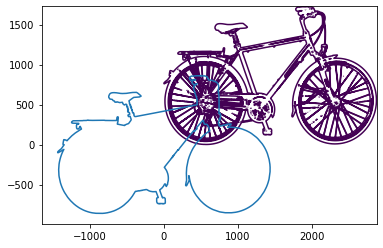

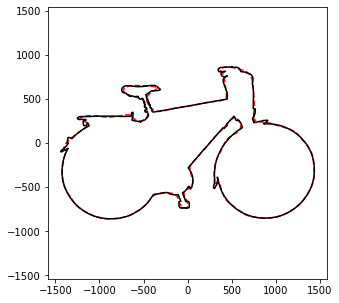

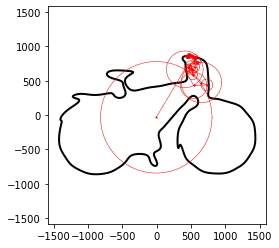

In [6]:
import matplotlib.pyplot as plt # for plotting and creating figures
import numpy as np # for easy and fast number calculation
from math import tau
from IPython.display import HTML


import draw_circle_fourier
from draw_circle_fourier import ImageReader
from draw_circle_fourier import Fourier
from draw_circle_fourier import DrawAnimation

#Part Kenjy 

image = ImageReader("https://raw.githubusercontent.com/Paul30hub/Fourier_transform_drawing/main/PACKAGE/draw_circle_fourier/DATA/velo.jpeg")
time_table, x_table, y_table = image.get_tour()
print(time_table, x_table, y_table)

#Part Chloe

order = 30

cf = Fourier(time_table, x_table, y_table,order)
fouriercoeff = cf.coef_list(time_table, x_table, y_table, order)

print(fouriercoeff)

#Part Paul+Pierre

space = np.linspace(0, tau, 300)
x_DFT = [cf.DFT(t, fouriercoeff, order)[0] for t in space]
y_DFT = [cf.DFT(t, fouriercoeff, order)[1] for t in space]

fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(x_DFT, y_DFT, 'r--')
ax.plot(x_table, y_table, 'k-')
ax.set_aspect('equal', 'datalim')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

b = DrawAnimation(x_DFT, y_DFT, fouriercoeff, order, space, [xmin, xmax, ymin, ymax])
anim = b.visualize(x_DFT, y_DFT, fouriercoeff, order, space, [xmin, xmax, ymin, ymax])

#Change based on what writer you have
#HTML(anim.to_html5_video())
#anim.save('pi.mp4',writer='ffmpeg')
anim.save('velo.gif', writer = 'pillow')